#   <center>  Agar floc notebook  <center> 
 <center> M. R. MacIver, 17 June 2019 <center> 

In [66]:
%matplotlib inline

import os

from IPython.display import HTML
from matplotlib import pylab
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.font_manager as fm
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.patches as mpatches
plt.style.use('mft_publication.mplstyle')

import os

import skimage.io as sio
import numpy as np
import pandas as pd

import skimage
import scipy.ndimage 
from skimage import restoration, exposure, segmentation, measure, img_as_float, morphology, util
from skimage.filters import gaussian
from skimage.morphology import remove_small_holes
from skimage.segmentation import random_walker
from skimage.measure import regionprops
from skimage.measure import label

import skimage.io as sio
from skimage.exposure import rescale_intensity
from skimage.filters import threshold_otsu
from skimage.segmentation import mark_boundaries


from skimage import exposure

In [89]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Processing test

### <font color='blue'>figure: segment_test</font>

Load an images to develop a segmentation strategy for this sample type. A random walker seems to work relatively well, but the rings are a problem. Filtering was not used when these images were reconstructed, so it is likely an improvement could be made if one were applied. 

/home/ryan/.local/lib/python3.7/site-packages/skimage/segmentation/random_walker_segmentation.py:399: UserWarning: "cg" mode will be used, but it may be slower than "bf" because SciPy was built without UMFPACK. Consider rebuilding SciPy with UMFPACK; this will greatly accelerate the conjugate gradient ("cg") solver. You may also install pyamg and run the random_walker function in "cg_mg" mode (see docstring).
  warn('"cg" mode will be used, but it may be slower than '
/home/ryan/.local/lib/python3.7/site-packages/skimage/morphology/misc.py:132: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NameError: name 'scalebar' is not defined

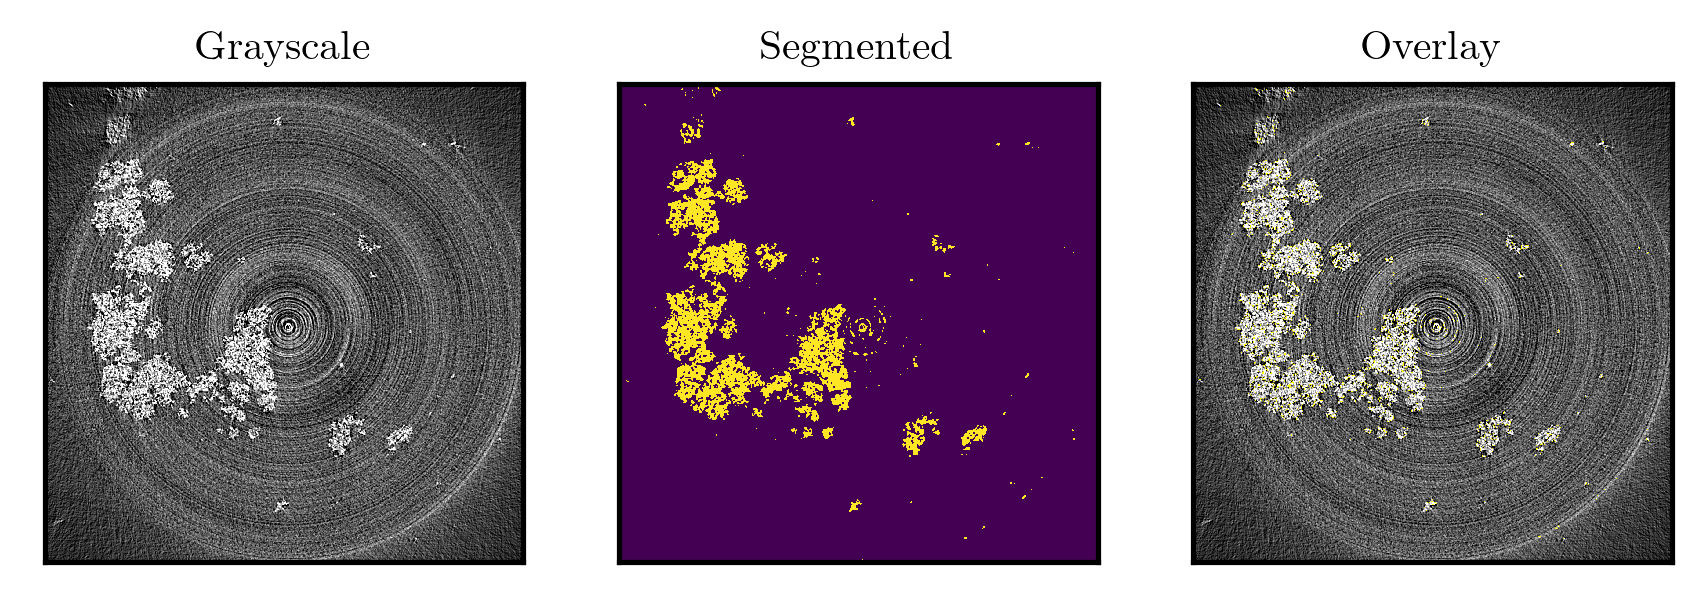

In [2]:


file = 'data/fig_segment_test/406_z0_sli-0025.tif'
im = sio.imread(file)

thresh =  [[-1, 0.1],
           [0.95, 1],]

# preprocess
im_filt = gaussian(im, sigma=2)
p2, p98 = np.percentile(im_filt, [2, 98])
im_rescale = rescale_intensity(im_filt, in_range=(p2, p98))   

# segment
labels = np.zeros(im_rescale.shape)  
labels[np.where(((im_rescale > thresh[0][0]) & (im_rescale < thresh[0][1])))] = 1
labels[np.where(((im_rescale > thresh[1][0]) & (im_rescale < thresh[1][1])))] = 2

rw = random_walker(im_rescale, labels, beta=50, mode='cg', tol=0.01)

# morphology on binaries only
rwe = np.zeros_like(rw)
rwe[np.where(rw==2)] = 1
rwe = morphology.remove_small_objects(rwe, min_size=100)

marked = mark_boundaries(im_rescale, rwe, color=[124,252,0])
                         
f, ax = plt.subplots(1,3, dpi=300, figsize=(7,3.5))
ax[0].imshow(im_rescale, cmap='gray')
ax[0].set_title('Grayscale')
ax[1].imshow(rwe)
ax[1].set_title('Segmented')
ax[2].imshow(marked)
ax[2].set_title('Overlay')
#plt.tight_layout()

for a in ax:
    a.set_yticklabels([])
    a.set_xticklabels([])
    a.set_yticks([])
    a.set_xticks([])

# fontprops = fm.FontProperties(size=9) 
# scalebar = AnchoredSizeBar(ax[0].transData,
#                    76.92, ' $250 \mu m$',
#                    loc = 'lower right',
#                    pad=0.25,
#                    color='black',
#                    frameon=True,
#                    size_vertical=5,
#                    fontproperties=fontprops,
#                    )

ax[0].add_artist(scalebar)

save = True
if save:
    fname = 'segment_test.png'
    fullname = os.path.join('png',fname)
    f.savefig(fullname,dpi=1000)


### <font color='blue'>figure: imhist</font>
Check the histogram of this image to check the overall segmentation efficiency. 



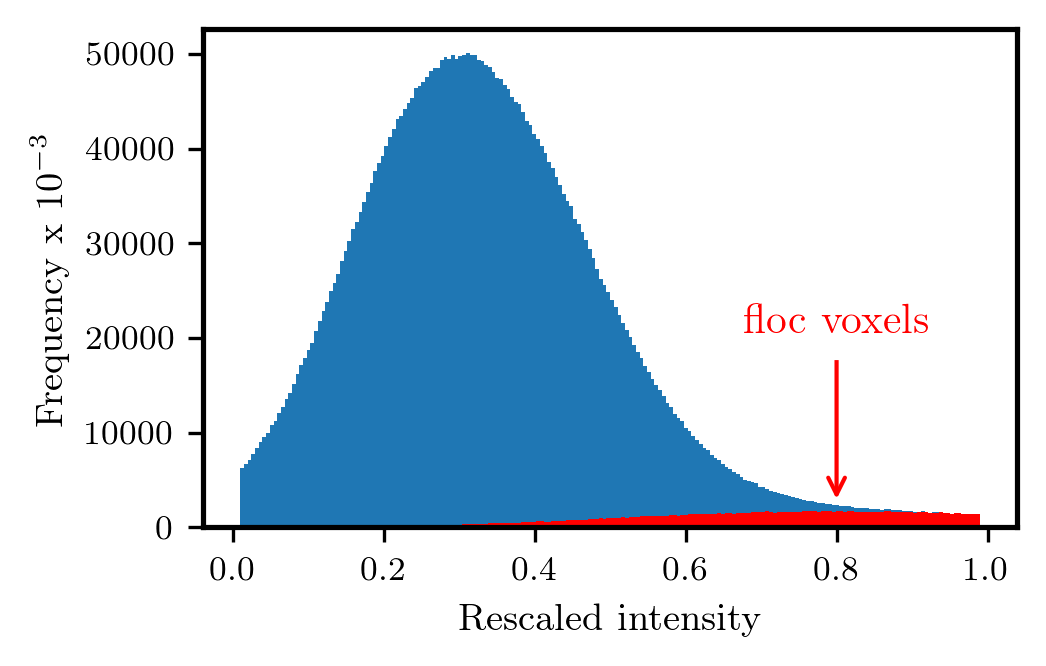

In [123]:
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

f, ax = plt.subplots(1,1, dpi=300, figsize=(3.5,2.2))

N, bins, patches1 = ax.hist(im_rescale.ravel(), bins=200, range=[0.01, 0.99])
ax.set_xlabel('Rescaled intensity')
ax.set_ylabel('Frequency x 10$^{-3}$')

floc_px = im_rescale[np.where(rwe==1)]
N, bins, patches1 = ax.hist(floc_px.ravel(), bins=200, range=[0.01, 0.99], color='red')

patch = mpatches.FancyArrowPatch([0.8 , 3000 ], [0.8 , 20000 ],
                                         shrinkA=0.0, shrinkB=0.0,
                                         arrowstyle='<-',
                                         edgecolor='red', 
                                         zorder=1,
                                         linewidth=1,
                                         mutation_scale=10)
ax.add_patch(patch)
ax.text(0.8, 20500, 'floc voxels', backgroundcolor='w', ha='center', color='red')

save = True
if save:
    fname = 'floc_voxels.png'
    fullname = os.path.join('png',fname)
    f.savefig(fullname,dpi=1000)

### <font color='blue'>figure: ct_crop</font>

Pre-process a cropped CT image.


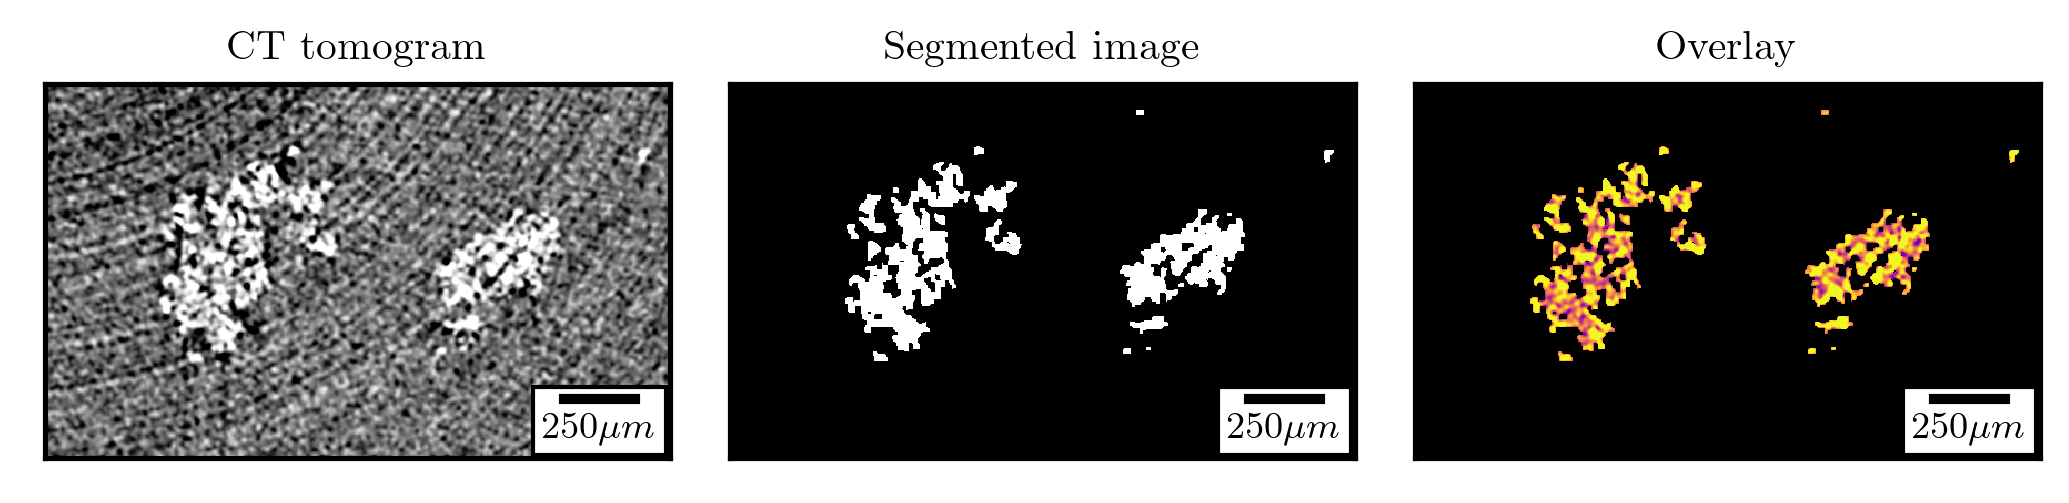

In [83]:
file = 'data/fig_struct/406_z0_sli-0025_crop.tif'
im = sio.imread(file)

thresh =  [[-1, 0.1],
           [0.9, 1],]

# preprocess
repro = False

if repro:
    im_filt = gaussian(im, sigma=2)
    p2, p98 = np.percentile(im_filt, [2, 98])
    im_rescale = rescale_intensity(im_filt, in_range=(p2, p98))   

    # # segment
    labels = np.zeros(im_rescale.shape)  
    labels[np.where(((im_rescale > thresh[0][0]) & (im_rescale < thresh[0][1])))] = 1
    labels[np.where(((im_rescale > thresh[1][0]) & (im_rescale < thresh[1][1])))] = 2
    rw = random_walker(im_rescale, labels, beta=500, mode='cg', tol=0.01)

    # # morphology on binaries only
    rwe = np.zeros_like(rw)
    rwe[np.where(rw==2)] = 1
    rwe = morphology.remove_small_objects(rwe, min_size=100)

    marked = mark_boundaries(im_rescale, rwe, color=[0, 255 ,0])


    imr = im_rescale.copy()
    imr[np.where(rwe==0)] = 0

f, ax = plt.subplots(1,3, dpi=300, figsize=(7, 2))
ax[0].imshow(im_rescale, cmap='Greys_r')
ax[0].set_title('CT tomogram')
ax[1].imshow(rwe, cmap='Greys_r')
ax[1].set_title('Segmented image')
cm1 = cm.get_cmap(name='plasma')
cm1.colors[0] = [0,0,0]
ax[2].imshow(imr, cmap=cm1)
ax[2].set_title('Overlay')

for a in ax:
    a.set_yticklabels([])
    a.set_xticklabels([])
    a.set_yticks([])
    a.set_xticks([])

fontprops = fm.FontProperties(size=9) 

for a in ax: 
    scalebar = AnchoredSizeBar(ax[0].transData,
                       69.44, ' $250 \mu m$',
                       loc = 'lower right',
                       pad=0.25,
                       color='black',
                       frameon=True,
                       size_vertical=5,
                       fontproperties=fontprops,
                       )

    a.add_artist(scalebar)

plt.tight_layout()

    
save = True
if save:
    fname = 'ct_crop.png'
    fullname = os.path.join('png',fname)
    f.savefig(fullname,dpi=1000)

### <font color='blue'>figure: struct_props</font>

Calculate and display some typical 2D properties.


In [201]:
# split the image in 2: 

xv, yv = np.meshgrid(np.arange(0,337), np.arange(0, 310), sparse=False, indexing='ij')
im1 = rwe[xv,yv]

xv, yv = np.meshgrid(np.arange(80,337), np.arange(311, 550), sparse=False, indexing='ij')
im2 = rwe[xv,yv]

L = label(im2)
P = regionprops(L)

A = []
for p in P:
    A.append(p.area)

    
y = P[0].coords[:,0]
x = P[0].coords[:,1]

# isolated floc
im3 = np.zeros_like(im2)
im3[y,x] = 1


im4 = np.zeros_like(im2)
im4[y,x] = 1



im4[(y+120), x] = 1

area 4318
centroid (78.46086150995832, 98.5764242704956)
perimeter 815.263022691402
major_axis_length 127.38638957338662
equivalent_diameter 74.14747705867296


Area, A 55961.3 $\mu$m$^{2}$         
Perimeter, P 2934.9 $\mu$m   
Major axis length, L 458.6 $\mu$m
Equiv. diameter, $d_e = 2\sqrt{\frac{A}{\pi}}$ 266.9 $\mu$m
Fractal dim., $f_d = 2 \frac{log[P]}{log[A]}$ 1.5


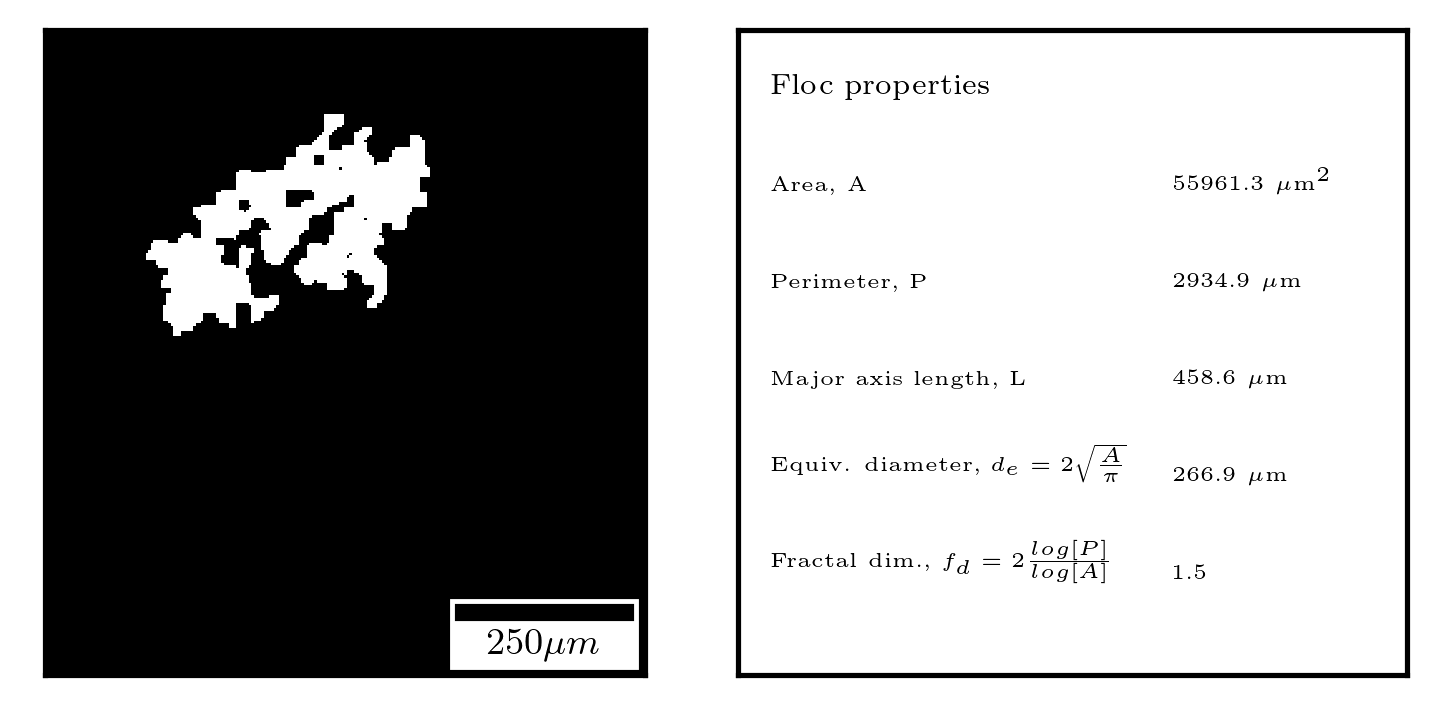

In [353]:
f, ax = plt.subplots(1,2, dpi=300, figsize=(5, 2.5))

ax[0].imshow(im3, cmap='Greys_r')


keys = ['Area, A', 
        'Perimeter, P', 
        'Major axis length, L', 
        r'Equiv. diameter, $d_e = 2\sqrt{\frac{A}{\pi}}$',
        r'Fractal dim., $f_d = 2 \frac{log[P]}{log[A]}$']

area = P[0]['area']*3.6*3.6
perimeter = P[0]['perimeter']*3.6
pal = P[0]['major_axis_length']*3.6
ed = P[0]['equivalent_diameter']*3.6
fd = 2*np.log(perimeter)/np.log(area)
props = [area, perimeter, pal, ed, fd]

vals = [('%0.1f $\mu$m$^{2}$         ' % area),
       ('%0.1f $\mu$m   ' % perimeter),
       ('%0.1f $\mu$m' % pal),
       ('%0.1f $\mu$m' % ed),
       ('%0.1f' % fd)]

h = 0.9
ax[1].text(0.05, h, 'Floc properties', bbox=dict(facecolor='w', alpha=0.9,linewidth=0 ), fontsize=7, )

for i, ky in enumerate(keys): 
    print(ky, vals[i])
    h -= 0.15

    ax[1].text(0.05, h, ky, bbox=dict(facecolor='w', alpha=0.9,linewidth=0 ), fontsize=5, )
    ax[1].text(0.65, h, vals[i], bbox=dict(facecolor='w', alpha=0.9,linewidth=0 ), fontsize=5, )
    
    
    
props = ['']

# derived props
# ed = P[0]['equivalent_diameter']*3.6

for a in ax:
    a.set_yticklabels([])
    a.set_xticklabels([])
    a.set_yticks([])
    a.set_xticks([])

# fontprops = fm.FontProperties(size=9) 

for a in [ax[0]]: 
    scalebar = AnchoredSizeBar(ax[0].transData,
                       69.44, ' $250 \mu m$',
                       loc = 'lower right',
                       pad=0.25,
                       color='black',
                       frameon=True,
                       size_vertical=5,
                       fontproperties=fontprops,
                       )

    a.add_artist(scalebar)
    
plt.tight_layout()

save = True
if save:
    fname = 'floc_prop.png'
    fullname = os.path.join('png',fname)
    f.savefig(fullname,dpi=1000)

(78.46086150995832, 98.5764242704956)
Distance, d 432.0 $\mu$m         


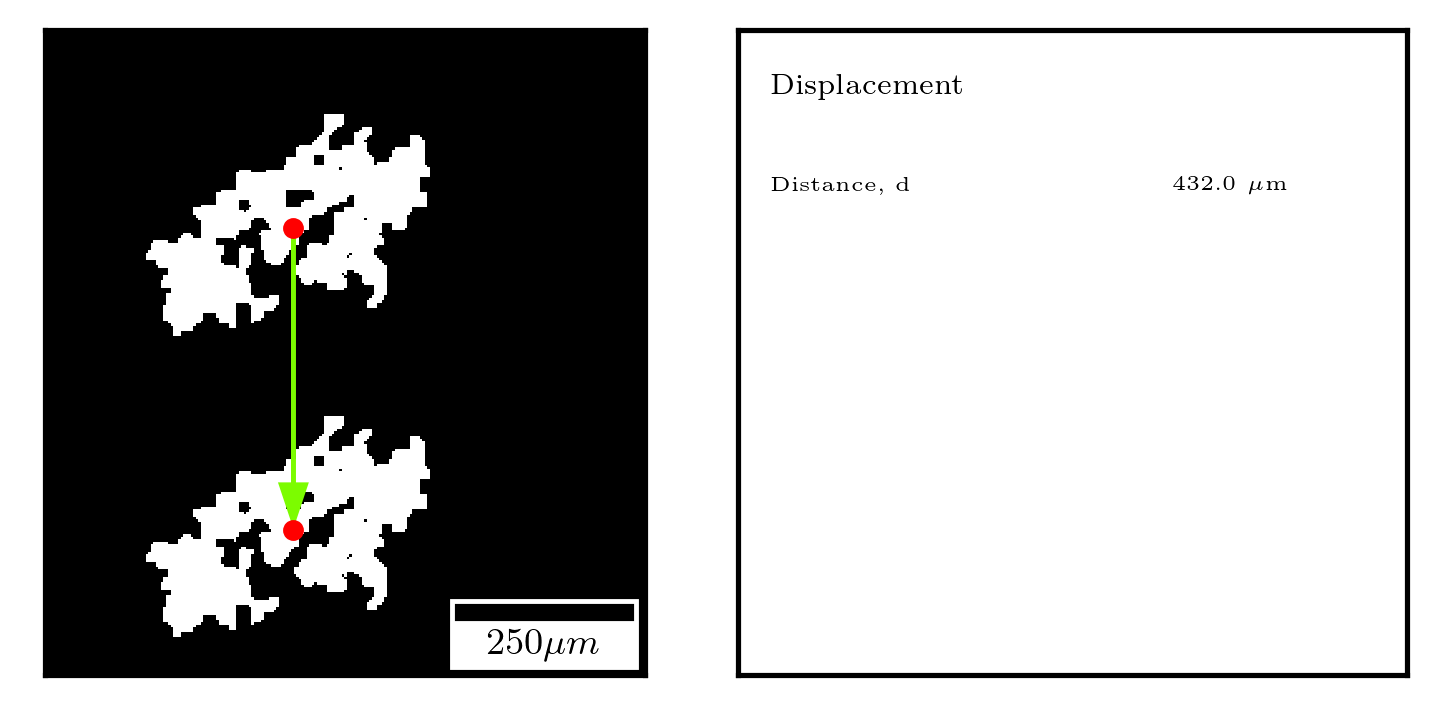

In [351]:
f, ax = plt.subplots(1,2, dpi=300, figsize=(5, 2.5))

L4 = label(im4)
M4 = regionprops(L4)

print(M4[0]['centroid'])



ax[0].imshow(im4, cmap='Greys_r')
ax[0].plot(M4[0]['centroid'][1], M4[0]['centroid'][0], marker='o', color='r')

ax[0].plot(M4[1]['centroid'][1], M4[1]['centroid'][0], marker='o', color='r')

alen = M4[1]['centroid'][0] - M4[0]['centroid'][0]
hw=10
ax[0].arrow(M4[0]['centroid'][1], M4[0]['centroid'][0], 0, (alen-hw-8), 
            color='lawngreen', head_width=hw)
h = 0.9
ax[1].text(0.05, h, 'Displacement', bbox=dict(facecolor='w', alpha=0.9,linewidth=0 ), fontsize=7, )

alenm = alen*3.6 
keys = ['Distance, d']
vals = [('%0.1f $\mu$m         ' % alenm),]
        
for i, ky in enumerate(keys): 
    print(ky, vals[i])
    h -= 0.15

    ax[1].text(0.05, h, ky, bbox=dict(facecolor='w', alpha=0.9,linewidth=0 ), fontsize=5, )
    ax[1].text(0.65, h, vals[i], bbox=dict(facecolor='w', alpha=0.9,linewidth=0 ), fontsize=5, )
    
    
    
for a in ax:
    a.set_yticklabels([])
    a.set_xticklabels([])
    a.set_yticks([])
    a.set_xticks([])
    
for a in [ax[0]]: 
    scalebar = AnchoredSizeBar(ax[0].transData,
                       69.44, ' $250 \mu m$',
                       loc = 'lower right',
                       pad=0.25,
                       color='black',
                       frameon=True,
                       size_vertical=5,
                       fontproperties=fontprops,
                       )

    a.add_artist(scalebar)

plt.tight_layout()

save = True

if save:
    fname = 'floc_disp.png'
    fullname = os.path.join('png',fname)
    f.savefig(fullname,dpi=1000)
    